# Deep Convolution Network - Image Recognition - CIFS 10 

In [ ]:

%pip install -q keras-tuner numpy imageio pydot tensorflow-gpu==2.9.1 keras

In [1]:
import keras_tuner as kt
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import mixed_precision
import tensorflow.keras.datasets.cifar100


In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:plt.show()

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 3070 Ti, compute capability 8.6


2022-06-05 12:07:27.411814: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-05 12:07:27.434605: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-05 12:07:27.434784: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-05 12:07:27.435705: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [3]:
print("TensorFlow version:", tf.__version__)


TensorFlow version: 2.9.1


## Setup DataSet

In [4]:
def loadDataCifar10():
	(train_images, train_labels), (test_images, test_labels) = tensorflow.keras.datasets.cifar10.load_data()
	class_names = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "ship", "horse", "ship", "truck"]

	TrainX = np.concatenate((train_images, test_images))
	TrainY = np.squeeze(np.concatenate((train_labels, test_labels)))
	# Normalize into [0,1], as float32
	TrainX = TrainX / 255.0

	return TrainX, TrainY, class_names


In [5]:

EPOCH = 96
BUFFER_SIZE = 192
BATCH_SIZE = 256

trainX, trainY, classes = loadDataCifar10()
IMAGE_SIZE = trainX[0].shape


## Show Example of DataSet

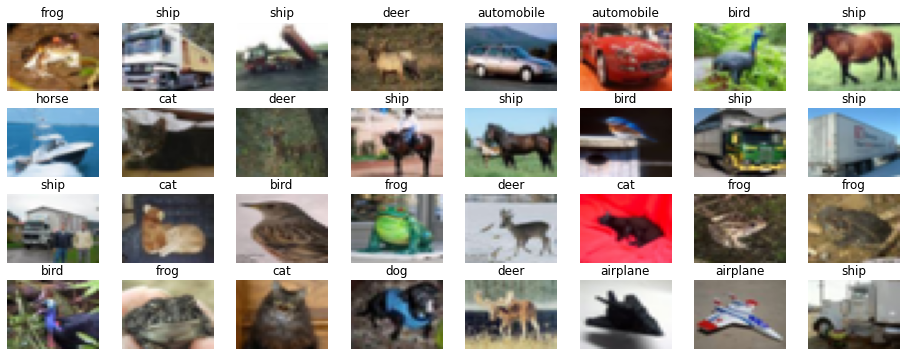

In [6]:
fig = plt.figure(figsize=(16, 6))
nrImage = 4 * 8
for index, (image, label) in enumerate(zip(trainX[0:nrImage], trainY[0:nrImage])):
    plt.subplot(4, 8, (index + 1))
    plt.title(label=str.format("{0}", classes[label]))

    plt.imshow(X=image.astype(dtype='float32'), cmap=plt.cm.gray, aspect='auto')
    plt.axis("off")
plt.subplots_adjust(wspace=0.25, hspace=0.25)
plt.show(block=False)


In [7]:
def plotCostHistory(history, loss_label="", val_label="", title="", x_label="", y_label=""):
    plt.figure()
    for k, v in history.items():
        plt.plot(v, label=k)
    plt.title(label=title)
    plt.ylabel(ylabel=y_label)
    plt.xlabel(xlabel=x_label)
    plt.legend(loc="upper left")
    plt.show()
    plt.savefig(title + ".png")


## Create Network with Hyperparameter
By using hyperparameter, a set of possible neuron network configuration can be setup. This allows to find network that are more optimal.

SparseCategoricalCrossentropy is used as the loss function. But also that it generates one-hot vector from an integer value that represents the categorical.

In [8]:

def generate_cnn_builder(hp, input, output):
    cnn_model = tf.keras.Sequential()
    #
    kernel_init = hp.Choice('kernel_initializer', ['uniform', 'lecun_uniform', 'normal', 'zero',
                                                   'glorot_normal', 'glorot_uniform', 'he_normal', 'he_uniform'])

    hp_kernel_filter_size_l0 = hp.Int(
        'kernel_filter_size_0', min_value=32, max_value=512, step=32)
    hp_kernel_filter_size_l1 = hp.Int(
        'kernel_filter_size_1', min_value=32, max_value=512, step=32)

    hp_strides_size_l0 = hp.Int(
        'hp_strides_size_l0', min_value=1, max_value=2, step=1)
    hp_strides_size_l1 = hp.Int(
        'hp_strides_size_l1', min_value=1, max_value=2, step=1)

    hp_kernel_size_l0 = hp.Int(
        'hp_kernel_size_l0', min_value=3, max_value=7, step=2)
    hp_kernel_size_l1 = hp.Int(
        'hp_kernel_size_l1', min_value=3, max_value=7, step=2)

    hp_max_pooling_size_l0 = hp.Int(
        'max_pooling_l0', min_value=1, max_value=3, step=1)
    hp_max_pooling_size_l1 = hp.Int(
        'max_pooling_l1', min_value=1, max_value=3, step=1)

    cnn_model.add(
        layers.Conv2D(filters=hp_kernel_filter_size_l0, kernel_size=(3, 3), strides=hp_strides_size_l0,
                      kernel_initializer=kernel_init, activation='relu',
                      padding='same',
                      input_shape=input))
    cnn_model.add(layers.MaxPooling2D(pool_size=hp_max_pooling_size_l0))

    cnn_model.add(
        layers.Conv2D(filters=hp_kernel_filter_size_l1, kernel_size=(3, 3), strides=hp_strides_size_l1,
                      activation='relu', padding='same', kernel_initializer=kernel_init))
    cnn_model.add(layers.MaxPooling2D(pool_size=hp_max_pooling_size_l1))

    cnn_model.add(layers.Flatten())

    hp_units = hp.Int('dense0_units', min_value=32, max_value=512, step=32)
    cnn_model.add(layers.Dense(units=hp_units, kernel_initializer=kernel_init))
    cnn_model.add(layers.Dense(units=output))

    cnn_model.summary()

    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

    cnn_model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                      loss=keras.losses.SparseCategoricalCrossentropy(
                          from_logits=True),
                      metrics=['accuracy'])

    return cnn_model


## Training
First the dataset is split into training and test data.

kt.Hyperband is used as the hyperparameter manager, where the model_builder is the function that will construct the convolutional network.

tuner.search will search the whole hyperparameter space and select the one that is best, and to prevent it having to run all epoch, an EarlyStopping is used to valdiate if the model performance good or not in the early stage of the learning.

In [9]:
# Neuron network input and output.
image_shape = trainX[0].shape
num_classes_output = len(classes)

train_X, test_X, train_y, test_y = train_test_split(
    trainX, trainY, shuffle=True, test_size=0.25)

print('X_train: ' + str(train_X.shape))
print('Y_train: ' + str(train_y.shape))
print('X_test:  ' + str(test_X.shape))
print('Y_test:  ' + str(test_y.shape))

def model_builder(hp):
    model = generate_cnn_builder(hp, image_shape, num_classes_output)
    return model


tuner = kt.Hyperband(model_builder,
                     objective='val_accuracy',
                     max_epochs=16,
                     factor=3,
                     directory='cache',
                     project_name=str.format('cnn - {0}', "cifs-10"))

stop_early = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=5)
tuner.search(train_X, train_y, validation_split=0.1, epochs=EPOCH, batch_size=BATCH_SIZE,
             callbacks=[stop_early], verbose=1)

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
best_models = tuner.get_best_models(4)


Trial 30 Complete [00h 01m 08s]
val_accuracy: 0.6779999732971191

Best val_accuracy So Far: 0.714888870716095
Total elapsed time: 00h 06m 04s
INFO:tensorflow:Oracle triggered exit
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 416)       11648     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 416)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 320)       1198400   
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 320)        0         
 2D)                                                             
                                                                 
 flatten

## Training the Best Model
Now the best model that was selected is constructed and trained on.

In [10]:
cnn_model = tuner.hypermodel.build(best_hps)
cnn_model.summary()
cnn_model_history = cnn_model.fit(train_X, train_y, epochs=EPOCH, batch_size=BATCH_SIZE)


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 32, 32, 416)       11648     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 16, 16, 416)      0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 16, 16, 320)       1198400   
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 5, 5, 320)        0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 8000)              0         
                                                                 
 dense_2 (Dense)             (None, 512)              

## Final Result

In [11]:
val_acc_per_epoch = cnn_model_history.history['accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: {0}'.format(best_epoch,))

cnn_model.evaluate(test_X, test_y, verbose=2)


Best epoch: 64
469/469 - 1s - loss: 2.2331 - accuracy: 0.7211 - 976ms/epoch - 2ms/step


[2.2331087589263916, 0.7210666537284851]

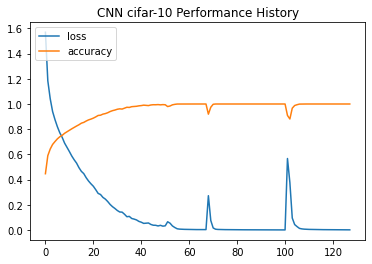

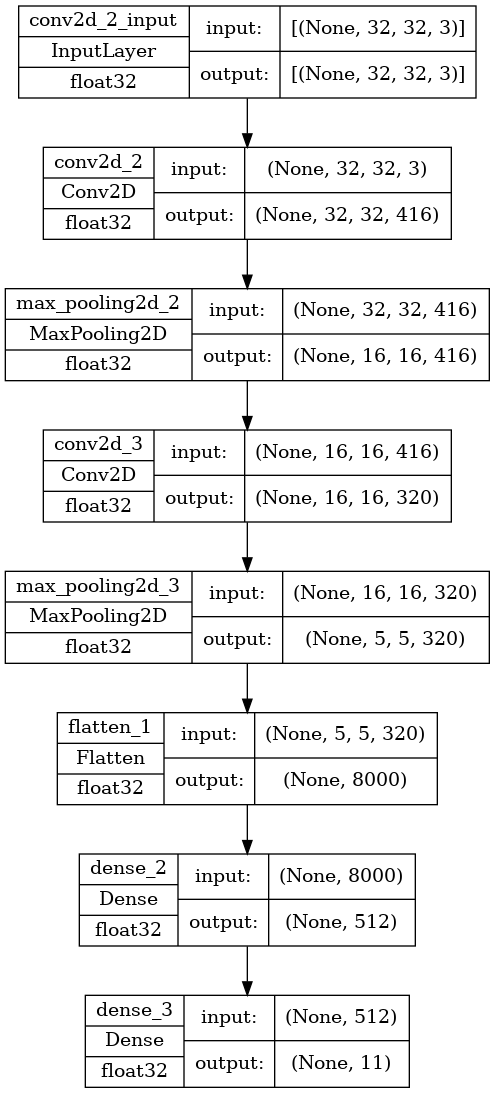

<Figure size 432x288 with 0 Axes>

In [12]:
plotCostHistory(cnn_model_history.history, title=str.format(
    "CNN {0} Performance History", "cifar-10"))

tf.keras.utils.plot_model(
    cnn_model, to_file=str.format('cnn_{0}_model.png', "cifar-10"), show_shapes=True, show_dtype=True,
    show_layer_names=True, rankdir='TB', expand_nested=False, dpi=96,
    layer_range=None
)
